Import Necessary libraries

In [50]:
# Data Libs 
import numpy as np
import pandas as pd
from openpyxl import load_workbook

# Classification Metrics
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score,roc_curve
from imblearn.metrics import specificity_score

# Classification Models Classes
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from keras.models import Sequential
from keras.layers import Dense

# Preprocessing lib
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Visual lib
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
modelN1 = 'LogisticClassifier'
modelN2 = 'GaussianNBClassifier'
modelN3 = 'DecisionTreeClassifier'
modelN4 = 'RandomForestClassifier'
modelN5 = 'SupportVectorClassifier'
modelN6 = 'KNClassifier'
modelN7 = 'SGDClassifier'
modelN8 = 'KernalApproximationSGDClassifier'
modelN9 = 'NeuralNetworkClassifier'

In [52]:
class TheClassifier:
    def __init__(self,dataset,sheet_name) -> None:
        self.sheet_name = sheet_name
        avgOfColumn = dataset.iloc[:,-1].mean()
        if sheet_name == "MicroHardness":
            dataset['MicroHardnessClass'] = dataset.apply(lambda row: 1 if row[-1] >= avgOfColumn else 0, axis = 1)
        elif sheet_name == "SurfaceRoughness":
            dataset['SurfaceRoughnessClass'] = dataset.apply(lambda row: 0 if row[-1] >= avgOfColumn else 1, axis = 1)
        elif sheet_name == "ThicknessOfLayerDeposited":
            dataset['ThicknessOfLayerDepositedClass'] = dataset.apply(lambda row: 0 if row[-1] >= avgOfColumn else 1, axis = 1)
        else:
            pass

        self.X,self.y =  dataset.iloc[:,1:-1],dataset.iloc[:,-1]

        self.LogC = LogisticRegression(random_state=0)
        self.GNBC = GaussianNB()
        self.DTC = DecisionTreeClassifier(random_state=0)
        self.RFC = RandomForestClassifier(max_depth=2, random_state=0)
        self.SVCls = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        self.KNC = KNeighborsClassifier(n_neighbors=3)
        self.SGDC = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
        kernal = RBFSampler(gamma=1, random_state=1)
        self.KASGDC = SGDClassifier(max_iter=5)

        self.NN = Sequential()
        self.NN.add(Dense(units=6, activation='relu'))
        # Second Hidden layer
        self.NN.add(Dense(units=6, activation='relu'))
        # Output layer
        self.NN.add(Dense(units=1, activation='sigmoid'))
        self.NN.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

    def find_corr(self):
        self.corr = self.dataset.corr()
        plt.figure(figsize=(20,9))
        hm = sns.heatmap(self.corr,cmap='crest',annot=True,fmt='.2f')
        plt.savefig(self.sheet_name+'ClassificationCorrelationHeatmap.png',bbox_inches="tight")

    def process_dataset(self,split_size = 0.3):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = split_size, random_state = 1)
        self.X_test,self.y_test = X_test,y_test

        # Linear Prediction
        self.LogC.fit(X_train,y_train)
        self.LogC_y_pred = self.LogC.predict(X_test)

        # GaussianNB Prediction
        self.GNBC.fit(X_train,y_train)
        self.GNBC_y_pred = self.GNBC.predict(X_test)

        # Decision Tree Prediction
        self.DTC.fit(X_train,y_train)
        self.DTC_y_pred = self.DTC.predict(X_test)

        # Random Forest Prediction
        self.RFC.fit(X_train,y_train)
        self.RFC_y_pred = self.RFC.predict(X_test)

        # Support Vector Prediction
        self.SVCls.fit(X_train, y_train)
        self.SVCls_y_pred = self.SVCls.predict(X_test)

        # KNN Prediction
        self.KNC.fit(X_train,y_train)
        self.KNC_y_pred = self.KNC.predict(X_test)

        # Stochastic Gradient Descent Prediction
        self.SGDC.fit(X_train,y_train)
        self.SGDC_y_pred = self.SGDC.predict(X_test)

        # Kernal Approximation with SGD Prediction
        rbf = RBFSampler(gamma=1, random_state=1)
        rbfX_train = rbf.fit_transform(X_train)
        self.KASGDC.fit(rbfX_train, y_train)
        rbfX_test = rbf.fit_transform(X_test)
        self.KASGDC_y_pred = self.KASGDC.predict(rbfX_test)

        # Neural Network Prediction
        sc = StandardScaler()
        Conv_X_train = sc.fit_transform(X_train)
        Conv_X_test = sc.transform(X_test)
        self.NN.fit(Conv_X_train, y_train,epochs=30,verbose=0)
        self.NN_y_pred = self.NN.predict(Conv_X_test) > 0.5

    def model_scores(self):
        ...

    def write_preds(self):
        predsheet = pd.DataFrame(self.X_test)
        predsheet["True "+self.sheet_name + " Class"] = self.y_test
        predsheet[modelN1] = self.LogC_y_pred
        predsheet[modelN2] = self.GNBC_y_pred
        predsheet[modelN3] = self.DTC_y_pred
        predsheet[modelN4] = self.RFC_y_pred
        predsheet[modelN5] = self.SVCls_y_pred
        predsheet[modelN6] = self.KNC_y_pred
        predsheet[modelN7] = self.SGDC_y_pred
        predsheet[modelN8] = self.KASGDC_y_pred
        predsheet[modelN9] = self.NN_y_pred
        return predsheet

In [53]:
MH_datasheet = pd.read_excel("CompleteDataWorksheet.xlsx",sheet_name="MicroHardness")
SR_datasheet = pd.read_excel("CompleteDataWorksheet.xlsx",sheet_name="SurfaceRoughness")
TLD_datasheet = pd.read_excel("CompleteDataWorksheet.xlsx",sheet_name="ThicknessOfLayerDeposited")
dataset_dict = {"MicroHardness":MH_datasheet,"SurfaceRoughness":SR_datasheet,"ThicknessOfLayerDeposited":TLD_datasheet}

C:\Users\Bharg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\Bharg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 58ms/step


C:\Users\Bharg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bharg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 53ms/step


C:\Users\Bharg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Bharg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 53ms/step


C:\Users\Bharg\AppData\Local\Temp\ipykernel_15788\3112556214.py:8: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


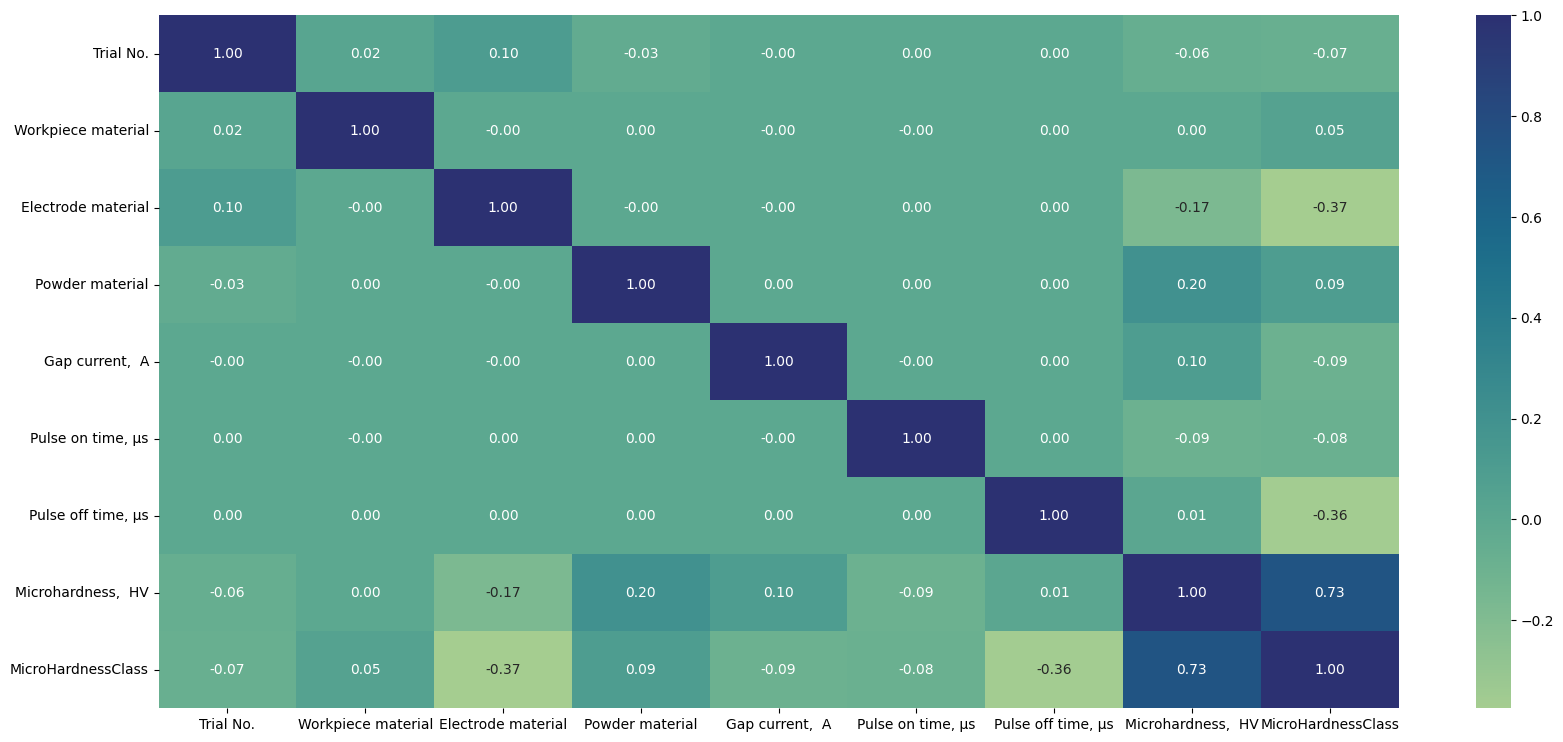

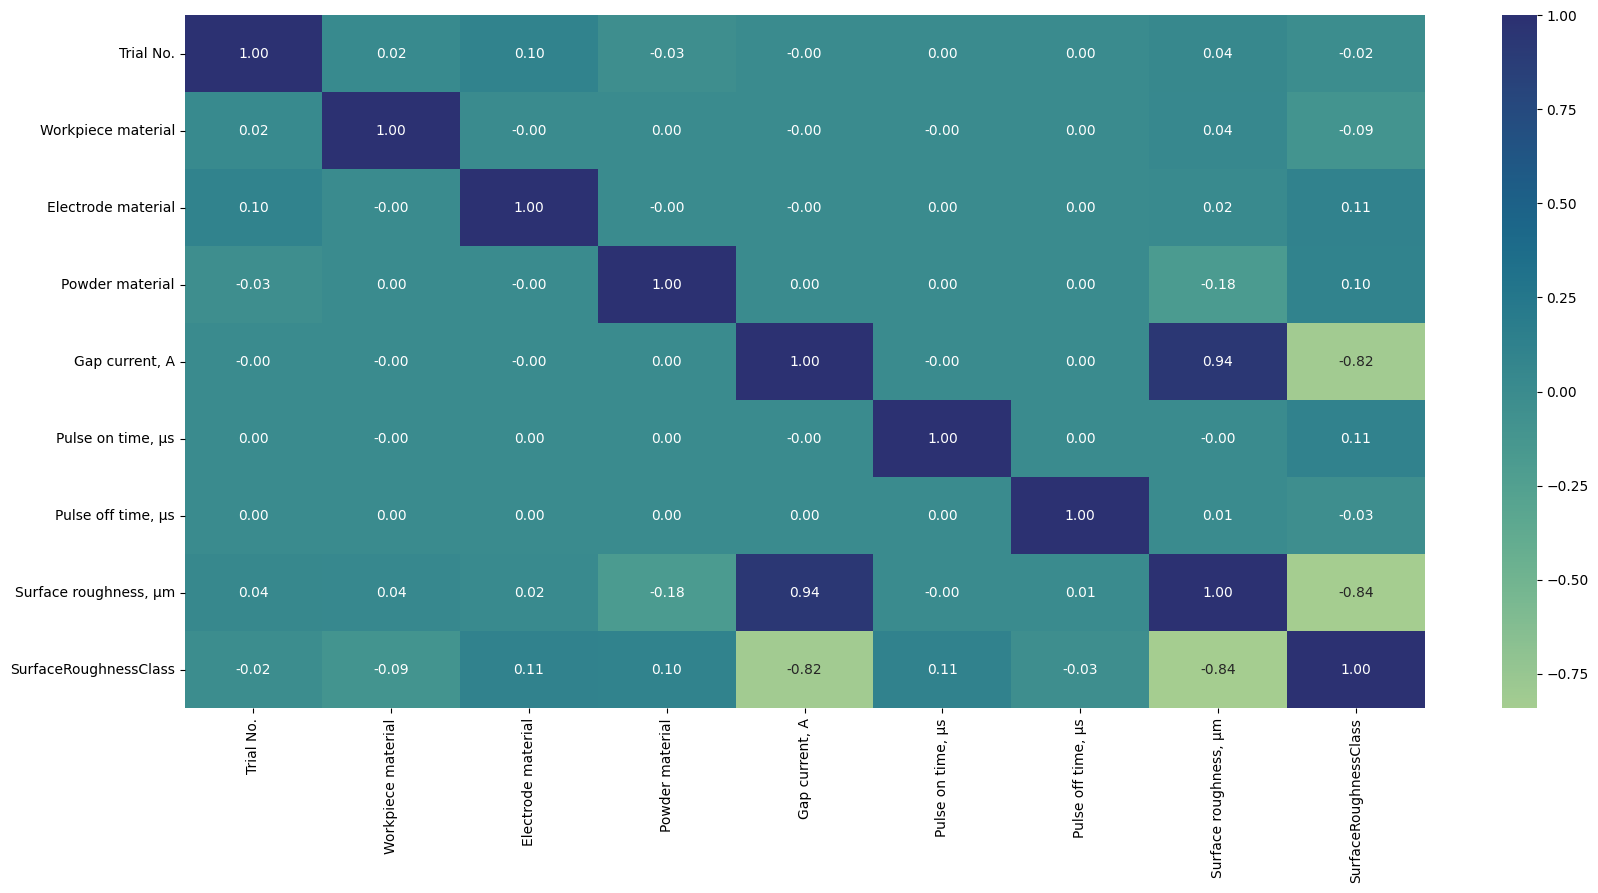

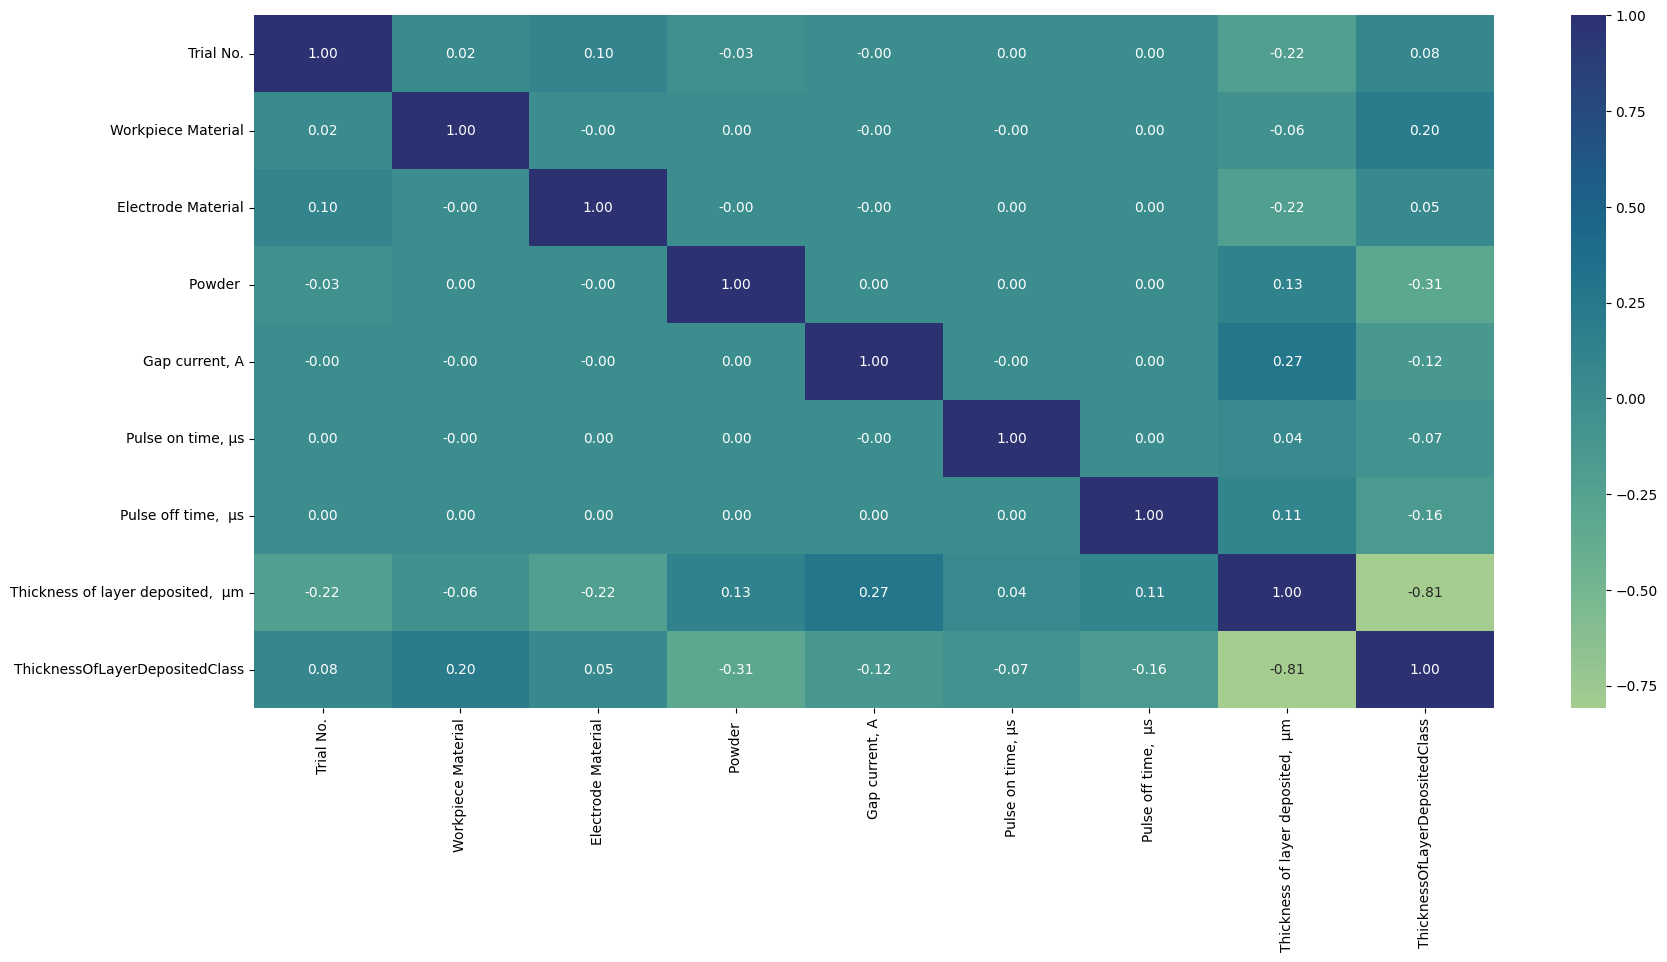

In [54]:
writer = pd.ExcelWriter('ClassificationPredictionResults.xlsx', engine='openpyxl')    
for sheet_name, dataset in dataset_dict.items():
    classy = TheClassifier(dataset=dataset,sheet_name=sheet_name)
    classy.find_corr()
    classy.process_dataset(split_size=0.3)
    s = classy.write_preds()
    s.to_excel(writer,sheet_name=sheet_name)
writer.save()
writer.close()